---
## Setup
---

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


**Install and upgrade librarys**


In [ ]:
!pip install --upgrade spacy
!python -m spacy download pt_core_news_lg
!pip install spacytextblob

     |████████████████████████████████| 12.8MB 5.0MB/s 
     |████████████████████████████████| 9.1MB 47.0MB/s 
     |████████████████████████████████| 1.1MB 38.3MB/s 
     |████████████████████████████████| 460kB 45.4MB/s 
     |████████████████████████████████| 122kB 54.2MB/s 
  Created wheel for smart-open: filename=smart_open-3.0.0-cp37-none-any.whl size=107098 sha256=ff8a3976813c85f6970729435fbd650f70118336de0513ab7d6a111455975acf
  Stored in directory: /root/.cache/pip/wheels/18/88/7c/f06dabd5e9cabe02d2269167bcacbbf9b47d0c0ff7d6ebcb78
Successfully built smart-open
  Found existing installation: smart-open 4.2.0
    Uninstalling smart-open-4.2.0:
      Successfully uninstalled smart-open-4.2.0
  Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Found existing installation: thinc 7.4.0
    U

**Mount google drive**

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


---
## **Import librarys**
---

In [ ]:
import numpy as np
import os
import json
import requests
import pandas as pd
import math
import re

import librosa
import librosa.display
import IPython.display as ipd

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
warnings.filterwarnings(action="ignore")
import gensim
from gensim.models import word2vec
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.decomposition import PCA

import spacy
from spacy.lang.pt.stop_words import STOP_WORDS
import string

os.chdir("/content/drive/MyDrive/phone-track-projects/ml/pht_calls_angry_approach/spacy")

%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


---
## Manual and Automatic Transcription
---

In [ ]:
df = pd.read_csv("Tweets_Mg.csv")

df.head()

,Unnamed: 0,Created At,Text,Geo Coordinates.latitude,Geo Coordinates.longitude,User Location,Username,User Screen Name,Retweet Count,Classificacao,Observação,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,0,Sun Jan 08 01:22:05 +0000 2017,���⛪ @ Catedral de Santo Antônio - Governador ...,NaN,NaN,Brasil,Leonardo C Schneider,LeoCSchneider,0,Neutro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Sun Jan 08 01:49:01 +0000 2017,"� @ Governador Valadares, Minas Gerais https:/...",-41.9333,-18.85,NaN,Wândell,klefnews,0,Neutro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Sun Jan 08 01:01:46 +0000 2017,"�� @ Governador Valadares, Minas Gerais https:...",-41.9333,-18.85,NaN,Wândell,klefnews,0,Neutro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Wed Jan 04 21:43:51 +0000 2017,��� https://t.co/BnDsO34qK0,NaN,NaN,NaN,Ana estudando,estudandoconcur,0,Neutro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Mon Jan 09 15:08:21 +0000 2017,��� PSOL vai questionar aumento de vereadores ...,NaN,NaN,NaN,Emily,Milly777,0,Negativo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data = df["Text"].values
labels_text = df["Classificacao"].values

labels = []

for value in labels_text:
    if (value == "Negativo"):
        labels.append(-1)
    elif (value == "Positivo"):
        labels.append(1)
    else:
        labels.append(0)

labels = np.array(labels)

data.shape, labels.shape

((8199,), (8199,))

---
## Preprocessing with Spacy
---

**Get trained pipelines in Portuguese**

Basically, this model contains as components:
*   tok2vec;
*   morphogizer;
*   parser;
*   senter;
*   ner;
*   attribute_ruler;
*   lemmatizer;



In [ ]:
nlp = spacy.load("pt_core_news_lg")

nlp.pipe_names

['tok2vec', 'morphologizer', 'parser', 'ner', 'attribute_ruler', 'lemmatizer']

In [ ]:
X = data.copy()
y = labels.copy()

X = np.array(X)
y = np.array(y)

print(f"Shape of dataset: {X.shape}")

Shape of dataset: (8199,)


**Feature Extraction**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split

In [ ]:
def spacy_tokenizer(sentence):
    global nlp

    my_tokens = nlp(sentence)
    my_tokens = [token.lemma_.lower().strip() for token in my_tokens if token.lemma_ != "UNK" and token.lemma_ != '<' and token.lemma_ != '>' and token.lemma_ != '.' and token.lemma_ != '']
    my_tokens = [token for token in my_tokens if token not in stop_words and token not in punctuations]

    
    return my_tokens



def clean_text(text):
    return text.strip().lower()


class predictors(TransformerMixin):


    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]

    
    def fit(self, X, y=None, **fit_params):
        return self
    

    def get_params(self, deep=True):
        return {}

**Split into train and test set**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print("Size of Train and Test Set")
print(f"Train: {X_train.shape}, Test: {X_test.shape}.")

Size of Train and Test Set
Train: (5739,), Test: (2460,).


---
## Applying Shallow Techniques
---

In [ ]:
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier


from sklearn.metrics import accuracy_score, classification_report


In [ ]:
vectorizer = CountVectorizer(tokenizer=spacy_tokenizer, ngram_range=(1, 1))
tfvectorizer = TfidfVectorizer(tokenizer=spacy_tokenizer)

punctuations = string.punctuation
stop_words = list(STOP_WORDS)

In [ ]:
result = {
    "train_accuracy": [],
    "test_accuracy": [],
}
ml_algorithms = ["Logistic Regression", "SGD Classifier", "Multinomial NB", "SVM Linear SVC", "SVM SVC",
                 "Random Forest", "Extra Trees Classifier", "Ada Boost", "Grandient Boosting"]

### Logistic Regression

In [ ]:
pipeline = Pipeline([
    ("cleaner", predictors()),
    ("tfvectorizer", vectorizer),
    ("classifier", LogisticRegression())
])

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('cleaner', <__main__.predictors object at 0x7f0d0cb16e10>),
                ('tfvectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function spacy_tokenizer at 0x7f0dd2bdc9e0>,
                                 vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scalin

In [ ]:
predictions = pipeline.predict(X_test)

for (sample, prediction) in zip(X_test, predictions):
    if (len(sample) < 500):
        print(f"Sample: {sample}, Predictions: {prediction}")
        break

Sample: RT @JDanieldf: Pedindo para que MG reaja? Reagir contra o governador queridinho dos eleitores mineiros? https://t.co/mMCw5wyyL8, Predictions: -1


In [ ]:
print(f"Train Accuracy: {pipeline.score(X_train, y_train)}")
print(f"Test Accuracy: {pipeline.score(X_test, y_test)}")

result["train_accuracy"].append(pipeline.score(X_train, y_train))
result["test_accuracy"].append(pipeline.score(X_test, y_test)) 

Train Accuracy: 0.997037811465412
Test Accuracy: 0.9630081300813008


In [ ]:
pipeline.predict(["Estou muito feliz com seu atendimento", "Péssimo atendimento, estou muito chateado com a situação",
                  "Eu queria agradecer pelo excelente atendimento que eu recebi", "Esse banco é uma merda não ajuda em nada"])

array([0, 0, 0, 1])

In [ ]:
angry_03 = "Boa tarde rodrigo tales tudo bem então rodrigo ta complicado né porque ligamos la na mecânica nem orçamenta tava aprovado ainda não foi não foi aprovado e ele falou que provavelmente vai algumas semanas pra eles aprova pra poder mecher no carro pra poder chegar perto ai ta complicado porque já tem dez dias que ta que o carro ta la se fica mais uma semana lá vai liberar uns vinte dias por favor se você puder ver isso porque a gente ligou lá e eles falaram não foi aprovado ainda o orçamento liberou nada ainda ta bom obrigada ta bom obrigada"
angry_02 = "Amigo eu to ligando pra um ai que, eu não pedi pra falar pra é pra reclamar, que é qualquer pessoa mas só fez chamar que um é que vocês atendem meu irmão só pra dizer que o serviço de vocês era mediano e agora ta de mediano pra pior o serviço ta uma merda se puder registar isso meu irmaozinho registre eu já tenho um carro da toyota há oito anos o serviço sempre foi mediano hoje vocês conseguem piorar um negócio que era razoável o serviço demora pra começar o pessoal do atendimento é grosso tem um rapaz que ta trabalhando hoje que é um cavalo é grosso"


pipeline.predict([angry_03, angry_02])

array([0, 0])

### SGD Classifier

In [ ]:
pipeline = Pipeline([
    ("cleaner", predictors()),
    ("tfvectorizer", vectorizer),
    ("classifier", SGDClassifier())
])

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('cleaner', <__main__.predictors object at 0x7f0d0edf8510>),
                ('tfvectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None...
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                               max_iter=1000, n_iter_no_change=5, n_jobs=None,
              

In [ ]:
predictions = pipeline.predict(X_test)

for (sample, prediction) in zip(X_test, predictions):
    if (len(sample) < 500):
        print(f"Sample: {sample}, Predictions: {prediction}")

Sample: RT @JDanieldf: Pedindo para que MG reaja? Reagir contra o governador queridinho dos eleitores mineiros? https://t.co/mMCw5wyyL8, Predictions: -1
Sample: Homem que matou ex-mulher e jogou corpo em cisterna contou com ajuda de amigo - Gerais - Estado de Minas https://t.co/BoRuUPDEBG, Predictions: 0
Sample: New post: "Três adolescentes são apreendidos por tráfico de drogas em Ipatinga" https://t.co/kdEixqMCiu, Predictions: 1
Sample: RT @AnaPaulaVolei: Mais 2 helicópteros!!A cara de pau e a canalhice ainda só ñ são maiores q a calamidade financeira q vive o estado.

 htt…, Predictions: -1
Sample: RT @UOLNoticias: Custaram R$ 21,8 milhões: Mesmo em calamidade, governo de MG compra mais dois helicópteros https://t.co/ijUc1AmjLZ, Predictions: -1
Sample: Alunos desocupam colégio da UFJF para não afetar conclusão do 3º ano https://t.co/n1YGGYnhOq, Predictions: 1
Sample: RT @diariopopularRS: #Alerta - Nome da CEEE é utilizado em golpe no Estado. https://t.co/i5ndsWhXR4 https://t.co/yaEM6

In [ ]:
print(f"Train Accuracy: {pipeline.score(X_train, y_train)}")
print(f"Test Accuracy: {pipeline.score(X_test, y_test)}")
result["train_accuracy"].append(pipeline.score(X_train, y_train))
result["test_accuracy"].append(pipeline.score(X_test, y_test))

Train Accuracy: 0.9989545216936748
Test Accuracy: 0.9638211382113822


In [ ]:
pipeline.predict(["Estou muito feliz com seu atendimento", "Péssimo atendimento, estou muito chateado com a situação",
                  "Eu queria agradecer pelo excelente atendimento que eu recebi", "Esse banco é uma merda não ajuda em nada"])

array([0, 0, 0, 1])

### Multinomial Naive Bayes

In [ ]:
pipeline = Pipeline([
    ("cleaner", predictors()),
    ("tfvectorizer", vectorizer),
    ("classifier", MultinomialNB())
])

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('cleaner', <__main__.predictors object at 0x7f0d0cb51350>),
                ('tfvectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function spacy_tokenizer at 0x7f0dd2bdc9e0>,
                                 vocabulary=None)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
predictions = pipeline.predict(X_test)

for (sample, prediction) in zip(X_test, predictions):
    if (len(sample) < 500):
        print(f"Sample: {sample}, Predictions: {prediction}")

Sample: RT @JDanieldf: Pedindo para que MG reaja? Reagir contra o governador queridinho dos eleitores mineiros? https://t.co/mMCw5wyyL8, Predictions: -1
Sample: Homem que matou ex-mulher e jogou corpo em cisterna contou com ajuda de amigo - Gerais - Estado de Minas https://t.co/BoRuUPDEBG, Predictions: 0
Sample: New post: "Três adolescentes são apreendidos por tráfico de drogas em Ipatinga" https://t.co/kdEixqMCiu, Predictions: 1
Sample: RT @AnaPaulaVolei: Mais 2 helicópteros!!A cara de pau e a canalhice ainda só ñ são maiores q a calamidade financeira q vive o estado.

 htt…, Predictions: -1
Sample: RT @UOLNoticias: Custaram R$ 21,8 milhões: Mesmo em calamidade, governo de MG compra mais dois helicópteros https://t.co/ijUc1AmjLZ, Predictions: -1
Sample: Alunos desocupam colégio da UFJF para não afetar conclusão do 3º ano https://t.co/n1YGGYnhOq, Predictions: 1
Sample: RT @diariopopularRS: #Alerta - Nome da CEEE é utilizado em golpe no Estado. https://t.co/i5ndsWhXR4 https://t.co/yaEM6

In [ ]:
print(f"Train Accuracy: {pipeline.score(X_train, y_train)}")
print(f"Test Accuracy: {pipeline.score(X_test, y_test)}")
result["train_accuracy"].append(pipeline.score(X_train, y_train))
result["test_accuracy"].append(pipeline.score(X_test, y_test))

Train Accuracy: 0.9717720857292211
Test Accuracy: 0.95


In [ ]:
pipeline.predict(["Estou muito feliz com seu atendimento", "Péssimo atendimento, estou muito chateado com a situação",
                  "Eu queria agradecer pelo excelente atendimento que eu recebi", "Esse banco é uma merda não ajuda em nada"])

array([ 0,  0,  0, -1])

### Linear SVM

In [ ]:
pipeline = Pipeline([
    ("cleaner", predictors()),
    ("tfvectorizer", vectorizer),
    ("classifier", LinearSVC())
])

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('cleaner', <__main__.predictors object at 0x7f0d0c978450>),
                ('tfvectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function spacy_tokenizer at 0x7f0dd2bdc9e0>,
                                 vocabulary=None)),
                ('classifier',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
              

In [ ]:
predictions = pipeline.predict(X_test)

for (sample, prediction) in zip(X_test, predictions):
    if (len(sample) < 500):
        print(f"Sample: {sample}, Predictions: {prediction}")

Sample: RT @JDanieldf: Pedindo para que MG reaja? Reagir contra o governador queridinho dos eleitores mineiros? https://t.co/mMCw5wyyL8, Predictions: -1
Sample: Homem que matou ex-mulher e jogou corpo em cisterna contou com ajuda de amigo - Gerais - Estado de Minas https://t.co/BoRuUPDEBG, Predictions: 0
Sample: New post: "Três adolescentes são apreendidos por tráfico de drogas em Ipatinga" https://t.co/kdEixqMCiu, Predictions: 1
Sample: RT @AnaPaulaVolei: Mais 2 helicópteros!!A cara de pau e a canalhice ainda só ñ são maiores q a calamidade financeira q vive o estado.

 htt…, Predictions: -1
Sample: RT @UOLNoticias: Custaram R$ 21,8 milhões: Mesmo em calamidade, governo de MG compra mais dois helicópteros https://t.co/ijUc1AmjLZ, Predictions: -1
Sample: Alunos desocupam colégio da UFJF para não afetar conclusão do 3º ano https://t.co/n1YGGYnhOq, Predictions: 1
Sample: RT @diariopopularRS: #Alerta - Nome da CEEE é utilizado em golpe no Estado. https://t.co/i5ndsWhXR4 https://t.co/yaEM6

In [ ]:
print(f"Train Accuracy: {pipeline.score(X_train, y_train)}")
print(f"Test Accuracy: {pipeline.score(X_test, y_test)}")
result["train_accuracy"].append(pipeline.score(X_train, y_train))
result["test_accuracy"].append(pipeline.score(X_test, y_test))

Train Accuracy: 0.9991287680780624
Test Accuracy: 0.9666666666666667


In [ ]:
pipeline.predict(["Estou muito feliz com seu atendimento", "Péssimo atendimento, estou muito chateado com a situação",
                  "Eu queria agradecer pelo excelente atendimento que eu recebi", "Esse banco é uma merda não ajuda em nada"])

array([ 0,  0,  0, -1])

### Support Vector Machine using Default SVC

In [ ]:
pipeline = Pipeline([
    ("cleaner", predictors()),
    ("tfvectorizer", vectorizer),
    ("classifier", SVC())
])

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('cleaner', <__main__.predictors object at 0x7f0d0c964cd0>),
                ('tfvectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function spacy_tokenizer at 0x7f0dd2bdc9e0>,
                                 vocabulary=None)),
                ('classifier',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', de

In [ ]:
predictions = pipeline.predict(X_test)

for (sample, prediction) in zip(X_test, predictions):
    if (len(sample) < 500):
        print(f"Sample: {sample}, Predictions: {prediction}")

Sample: RT @JDanieldf: Pedindo para que MG reaja? Reagir contra o governador queridinho dos eleitores mineiros? https://t.co/mMCw5wyyL8, Predictions: -1
Sample: Homem que matou ex-mulher e jogou corpo em cisterna contou com ajuda de amigo - Gerais - Estado de Minas https://t.co/BoRuUPDEBG, Predictions: 0
Sample: New post: "Três adolescentes são apreendidos por tráfico de drogas em Ipatinga" https://t.co/kdEixqMCiu, Predictions: 1
Sample: RT @AnaPaulaVolei: Mais 2 helicópteros!!A cara de pau e a canalhice ainda só ñ são maiores q a calamidade financeira q vive o estado.

 htt…, Predictions: -1
Sample: RT @UOLNoticias: Custaram R$ 21,8 milhões: Mesmo em calamidade, governo de MG compra mais dois helicópteros https://t.co/ijUc1AmjLZ, Predictions: -1
Sample: Alunos desocupam colégio da UFJF para não afetar conclusão do 3º ano https://t.co/n1YGGYnhOq, Predictions: 1
Sample: RT @diariopopularRS: #Alerta - Nome da CEEE é utilizado em golpe no Estado. https://t.co/i5ndsWhXR4 https://t.co/yaEM6

In [ ]:
print(f"Train Accuracy: {pipeline.score(X_train, y_train)}")
print(f"Test Accuracy: {pipeline.score(X_test, y_test)}")
result["train_accuracy"].append(pipeline.score(X_train, y_train))
result["test_accuracy"].append(pipeline.score(X_test, y_test))

Train Accuracy: 0.9898937097055236
Test Accuracy: 0.9626016260162602


In [ ]:
pipeline.predict(["Estou muito feliz com seu atendimento", "Péssimo atendimento, estou muito chateado com a situação",
                  "Eu queria agradecer pelo excelente atendimento que eu recebi", "Esse banco é uma merda não ajuda em nada"])

array([0, 0, 0, 0])

### Random Forest Classifier

In [ ]:
pipeline = Pipeline([
    ("cleaner", predictors()),
    ("tfvectorizer", vectorizer),
    ("classifier", RandomForestClassifier())
])

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('cleaner', <__main__.predictors object at 0x7f0d0c937f90>),
                ('tfvectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
             

In [ ]:
predictions = pipeline.predict(X_test)

for (sample, prediction) in zip(X_test, predictions):
    if (len(sample) < 500):
        print(f"Sample: {sample}, Predictions: {prediction}")

Sample: RT @JDanieldf: Pedindo para que MG reaja? Reagir contra o governador queridinho dos eleitores mineiros? https://t.co/mMCw5wyyL8, Predictions: -1
Sample: Homem que matou ex-mulher e jogou corpo em cisterna contou com ajuda de amigo - Gerais - Estado de Minas https://t.co/BoRuUPDEBG, Predictions: 0
Sample: New post: "Três adolescentes são apreendidos por tráfico de drogas em Ipatinga" https://t.co/kdEixqMCiu, Predictions: 1
Sample: RT @AnaPaulaVolei: Mais 2 helicópteros!!A cara de pau e a canalhice ainda só ñ são maiores q a calamidade financeira q vive o estado.

 htt…, Predictions: -1
Sample: RT @UOLNoticias: Custaram R$ 21,8 milhões: Mesmo em calamidade, governo de MG compra mais dois helicópteros https://t.co/ijUc1AmjLZ, Predictions: -1
Sample: Alunos desocupam colégio da UFJF para não afetar conclusão do 3º ano https://t.co/n1YGGYnhOq, Predictions: 1
Sample: RT @diariopopularRS: #Alerta - Nome da CEEE é utilizado em golpe no Estado. https://t.co/i5ndsWhXR4 https://t.co/yaEM6

In [ ]:
print(f"Train Accuracy: {pipeline.score(X_train, y_train)}")
print(f"Test Accuracy: {pipeline.score(X_test, y_test)}")
result["train_accuracy"].append(pipeline.score(X_train, y_train))
result["test_accuracy"].append(pipeline.score(X_test, y_test))

Train Accuracy: 0.9991287680780624
Test Accuracy: 0.9621951219512195


In [ ]:
pipeline.predict(["Estou muito feliz com seu atendimento", "Péssimo atendimento, estou muito chateado com a situação",
                  "Eu queria agradecer pelo excelente atendimento que eu recebi", "Esse banco é uma merda não ajuda em nada"])

array([0, 0, 0, 0])

### Extra Tree Classifier

In [ ]:
pipeline = Pipeline([
    ("cleaner", predictors()),
    ("tfvectorizer", vectorizer),
    ("classifier", ExtraTreesClassifier())
])

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('cleaner', <__main__.predictors object at 0x7f0d19f2bb10>),
                ('tfvectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None...
                 ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                      class_weight=None, criterion='gini',
                                      max_depth=None, max_features='auto',
                                      max_leaf_nodes=None, max_samples=None,
                                      min_impurity_decrease=0.0,
                      

In [ ]:
predictions = pipeline.predict(X_test)

for (sample, prediction) in zip(X_test, predictions):
    if (len(sample) < 500):
        print(f"Sample: {sample}, Predictions: {prediction}")

Sample: RT @JDanieldf: Pedindo para que MG reaja? Reagir contra o governador queridinho dos eleitores mineiros? https://t.co/mMCw5wyyL8, Predictions: -1
Sample: Homem que matou ex-mulher e jogou corpo em cisterna contou com ajuda de amigo - Gerais - Estado de Minas https://t.co/BoRuUPDEBG, Predictions: 0
Sample: New post: "Três adolescentes são apreendidos por tráfico de drogas em Ipatinga" https://t.co/kdEixqMCiu, Predictions: 1
Sample: RT @AnaPaulaVolei: Mais 2 helicópteros!!A cara de pau e a canalhice ainda só ñ são maiores q a calamidade financeira q vive o estado.

 htt…, Predictions: -1
Sample: RT @UOLNoticias: Custaram R$ 21,8 milhões: Mesmo em calamidade, governo de MG compra mais dois helicópteros https://t.co/ijUc1AmjLZ, Predictions: -1
Sample: Alunos desocupam colégio da UFJF para não afetar conclusão do 3º ano https://t.co/n1YGGYnhOq, Predictions: 1
Sample: RT @diariopopularRS: #Alerta - Nome da CEEE é utilizado em golpe no Estado. https://t.co/i5ndsWhXR4 https://t.co/yaEM6

In [ ]:
print(f"Train Accuracy: {pipeline.score(X_train, y_train)}")
print(f"Test Accuracy: {pipeline.score(X_test, y_test)}")
result["train_accuracy"].append(pipeline.score(X_train, y_train))
result["test_accuracy"].append(pipeline.score(X_test, y_test))

Train Accuracy: 0.9991287680780624
Test Accuracy: 0.9654471544715447


In [ ]:
pipeline.predict(["Estou muito feliz com seu atendimento", "Péssimo atendimento, estou muito chateado com a situação",
                  "Eu queria agradecer pelo excelente atendimento que eu recebi", "Esse banco é uma merda não ajuda em nada"])

array([0, 0, 0, 0])

### Ada Boost Classifier

In [ ]:
pipeline = Pipeline([
    ("cleaner", predictors()),
    ("tfvectorizer", vectorizer),
    ("classifier", AdaBoostClassifier())
])

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('cleaner', <__main__.predictors object at 0x7f0d0f11b0d0>),
                ('tfvectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function spacy_tokenizer at 0x7f0dd2bdc9e0>,
                                 vocabulary=None)),
                ('classifier',
                 AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                                    learning_rate=1.0, n_estimators=

In [ ]:
predictions = pipeline.predict(X_test)

for (sample, prediction) in zip(X_test, predictions):
    if (len(sample) < 500):
        print(f"Sample: {sample}, Predictions: {prediction}")

Sample: RT @JDanieldf: Pedindo para que MG reaja? Reagir contra o governador queridinho dos eleitores mineiros? https://t.co/mMCw5wyyL8, Predictions: -1
Sample: Homem que matou ex-mulher e jogou corpo em cisterna contou com ajuda de amigo - Gerais - Estado de Minas https://t.co/BoRuUPDEBG, Predictions: 0
Sample: New post: "Três adolescentes são apreendidos por tráfico de drogas em Ipatinga" https://t.co/kdEixqMCiu, Predictions: 1
Sample: RT @AnaPaulaVolei: Mais 2 helicópteros!!A cara de pau e a canalhice ainda só ñ são maiores q a calamidade financeira q vive o estado.

 htt…, Predictions: -1
Sample: RT @UOLNoticias: Custaram R$ 21,8 milhões: Mesmo em calamidade, governo de MG compra mais dois helicópteros https://t.co/ijUc1AmjLZ, Predictions: -1
Sample: Alunos desocupam colégio da UFJF para não afetar conclusão do 3º ano https://t.co/n1YGGYnhOq, Predictions: 0
Sample: RT @diariopopularRS: #Alerta - Nome da CEEE é utilizado em golpe no Estado. https://t.co/i5ndsWhXR4 https://t.co/yaEM6

In [ ]:
print(f"Train Accuracy: {pipeline.score(X_train, y_train)}")
print(f"Test Accuracy: {pipeline.score(X_test, y_test)}")
result["train_accuracy"].append(pipeline.score(X_train, y_train))
result["test_accuracy"].append(pipeline.score(X_test, y_test))

Train Accuracy: 0.912528315037463
Test Accuracy: 0.9040650406504065


In [ ]:
pipeline.predict(["Estou muito feliz com seu atendimento", "Péssimo atendimento, estou muito chateado com a situação",
                  "Eu queria agradecer pelo excelente atendimento que eu recebi", "Esse banco é uma merda não ajuda em nada"])

array([0, 0, 0, 0])

### Gradient Boost Classifier

In [ ]:
pipeline = Pipeline([
    ("cleaner", predictors()),
    ("tfvectorizer", vectorizer),
    ("classifier", GradientBoostingClassifier())
])

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('cleaner', <__main__.predictors object at 0x7f0d0cc472d0>),
                ('tfvectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None...
                                            learning_rate=0.1, loss='deviance',
                                            max_depth=3, max_features=None,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                       

In [ ]:
predictions = pipeline.predict(X_test)

for (sample, prediction) in zip(X_test, predictions):
    if (len(sample) < 500):
        print(f"Sample: {sample}, Predictions: {prediction}")

Sample: RT @JDanieldf: Pedindo para que MG reaja? Reagir contra o governador queridinho dos eleitores mineiros? https://t.co/mMCw5wyyL8, Predictions: -1
Sample: Homem que matou ex-mulher e jogou corpo em cisterna contou com ajuda de amigo - Gerais - Estado de Minas https://t.co/BoRuUPDEBG, Predictions: 0
Sample: New post: "Três adolescentes são apreendidos por tráfico de drogas em Ipatinga" https://t.co/kdEixqMCiu, Predictions: 1
Sample: RT @AnaPaulaVolei: Mais 2 helicópteros!!A cara de pau e a canalhice ainda só ñ são maiores q a calamidade financeira q vive o estado.

 htt…, Predictions: -1
Sample: RT @UOLNoticias: Custaram R$ 21,8 milhões: Mesmo em calamidade, governo de MG compra mais dois helicópteros https://t.co/ijUc1AmjLZ, Predictions: -1
Sample: Alunos desocupam colégio da UFJF para não afetar conclusão do 3º ano https://t.co/n1YGGYnhOq, Predictions: 1
Sample: RT @diariopopularRS: #Alerta - Nome da CEEE é utilizado em golpe no Estado. https://t.co/i5ndsWhXR4 https://t.co/yaEM6

In [ ]:
print(f"Train Accuracy: {pipeline.score(X_train, y_train)}")
print(f"Test Accuracy: {pipeline.score(X_test, y_test)}")
result["train_accuracy"].append(pipeline.score(X_train, y_train))
result["test_accuracy"].append(pipeline.score(X_test, y_test))

Train Accuracy: 0.9546959400592437
Test Accuracy: 0.9378048780487804


In [ ]:
pipeline.predict(["Estou muito feliz com seu atendimento", "Péssimo atendimento, estou muito chateado com a situação",
                  "Eu queria agradecer pelo excelente atendimento que eu recebi", "Esse banco é uma merda não ajuda em nada"])

array([0, 0, 0, 0])

In [ ]:
angry_03 = "Boa tarde rodrigo tales tudo bem então rodrigo ta complicado né porque ligamos la na mecânica nem orçamenta tava aprovado ainda não foi não foi aprovado e ele falou que provavelmente vai algumas semanas pra eles aprova pra poder mecher no carro pra poder chegar perto ai ta complicado porque já tem dez dias que ta que o carro ta la se fica mais uma semana lá vai liberar uns vinte dias por favor se você puder ver isso porque a gente ligou lá e eles falaram não foi aprovado ainda o orçamento liberou nada ainda ta bom obrigada ta bom obrigada"
angry_02 = "Amigo eu to ligando pra um ai que, eu não pedi pra falar pra é pra reclamar, que é qualquer pessoa mas só fez chamar que um é que vocês atendem meu irmão só pra dizer que o serviço de vocês era mediano e agora ta de mediano pra pior o serviço ta uma merda se puder registar isso meu irmaozinho registre eu já tenho um carro da toyota há oito anos o serviço sempre foi mediano hoje vocês conseguem piorar um negócio que era razoável o serviço demora pra começar o pessoal do atendimento é grosso tem um rapaz que ta trabalhando hoje que é um cavalo é grosso"
pipeline.predict([angry_03, angry_02])

array([0, 0])

### Results

In [ ]:
df_result = pd.DataFrame({"ML Algorithms": ml_algorithms, "Train Accuracy": result["train_accuracy"], "Test Accuracy": result["test_accuracy"]})

df_result.head()

,ML Algorithms,Train Accuracy,Test Accuracy
0,Logistic Regression,0.997038,0.963008
1,SGD Classifier,0.998955,0.963821
2,Multinomial NB,0.971772,0.950000
3,SVM Linear SVC,0.999129,0.966667
4,SVM SVC,0.989894,0.962602


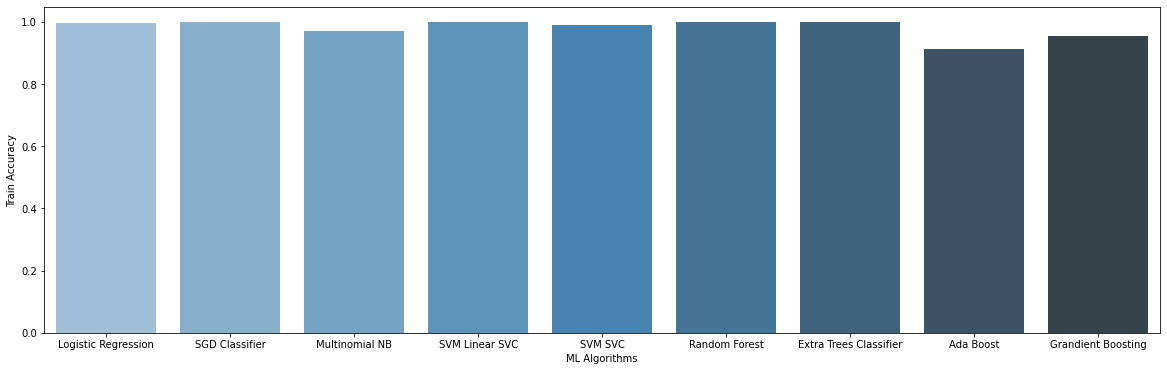

In [ ]:
fig = plt.figure(figsize=(20, 6))
sns.barplot(x=df_result['ML Algorithms'], y=df_result['Train Accuracy'], data=df_result, palette="Blues_d")

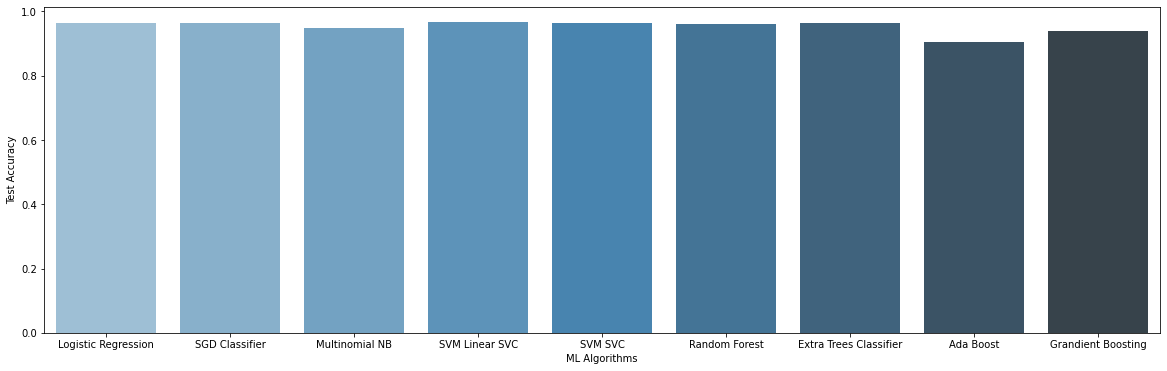

In [ ]:
fig = plt.figure(figsize=(20, 6))
sns.barplot(x=df_result['ML Algorithms'], y=df_result['Test Accuracy'], data=df_result, palette="Blues_d")

In [ ]:

my_tokens = nlp(str(X_train[6]))
my_tokens = [token.lemma_.lower().strip() for token in my_tokens if token.lemma_ != "UNK" and token.lemma_ != '<' and token.lemma_ != '>' and token.lemma_ != '.' and token.lemma_ != '']
my_tokens = [token for token in my_tokens if token not in stop_words and token not in punctuations]

print(f"Lemmas: {my_tokens}\nLabel: {y_train[6]}")

Lemmas: ['rt', '@uolnoticias', 'custaram', 'r$', '21,8', 'milhão', 'calamidade', 'governar', 'mg', 'comprar', 'helicóptero', 'https://t.co/ijuc1amjlz']
Label: -1


In [ ]:

my_tokens = nlp(str(X_train[20]))
my_tokens = [token.lemma_.lower().strip() for token in my_tokens if token.lemma_ != "UNK" and token.lemma_ != '<' and token.lemma_ != '>' and token.lemma_ != '.' and token.lemma_ != '']
my_tokens = [token for token in my_tokens if token not in stop_words and token not in punctuations]

print(f"Lemmas: {my_tokens}\nLabel: {y_train[20]}")

Lemmas: ['polícia', 'civil', 'minas', 'gerais', 'prender', 'ex-vereador', 'esmeraldas', 'acusar', 'tráfico', 'drogar', '…', 'https://t.co/jwwju8xprp', 'https://t.co/fasybfntso']
Label: 1


---
## Using pre-trained model
---

In [ ]:
from gensim.models.callbacks import CallbackAny2Vec

class EpochLogger(CallbackAny2Vec):
    '''Callback to log information about training'''

    def __init__(self):
        self.epoch = 0

    def on_epoch_begin(self, model):
        print("Epoch #{} start".format(self.epoch))

    def on_epoch_end(self, model):
        print("Epoch #{} end".format(self.epoch))
        self.epoch += 1

epoch_logger = EpochLogger()
w2v_model = Word2Vec.load('word2vec_Full_ch_both_300_100_Automotivo_5.model')

In [ ]:
data_augmentation = {
    "id": [],
    "adjs": [],   
}



for id, x in enumerate(X_train):
    doc = nlp(str(x))
    most_similar_adjs = {
        "adj": [],
        "adjs_similar": [],
    }
    data_augmentation["id"].append(id)
    for token in doc:
        if (token.pos_ == "ADJ"):
            result_similar = None
            try:
                result_similar = w2v_model.most_similar(token.text)
            except:
                pass

            if (result_similar is not None):
    
                most_similar_adjs["adj"].append(token.text)
                result_similar = [value[0] for value in result_similar]
                most_similar_adjs["adjs_similar"].append(result_similar)
    data_augmentation["adjs"].append(most_similar_adjs)

In [ ]:
X_train[0], y_train[0]

('\n        alô bom dia é eu tava vendo foi feito com crédito na minha conta de uma \n        renovação de um empréstimo eu não concordei com essa renovação de empréstimo \n        tome informei lá na caixa do ministério que eu fiz o do do boleto pra poder pra \n        poder quitar pra poder pagar é tão boleto pro meu email não ele foi feito eu \n        pesquisei aqui ele tá com fixa e o número que que na internet me aparece o \n        fixo é esse zero oitocentos tá porque aqui aparece o zero mas porque que \n        aparece zero oitocentos e você e esse número tá então eu vou no procon conta \n        que eu acho que a única forma a gente resolver isso tá bom obrigado .\n        ',
 1)

In [ ]:
X_train.shape, X_test.shape

((28,), (12,))

In [ ]:
w2v_model.most_similar("mal")

[('educado', 0.2974068522453308),
 ('percebi', 0.24581485986709595),
 ('entendido', 0.2439168393611908),
 ('transtorno', 0.24300573766231537),
 ('ocupado', 0.23643800616264343),
 ('tempo', 0.23288103938102722),
 ('falhando', 0.23087188601493835),
 ('voltando', 0.22548645734786987),
 ('foi', 0.21614763140678406),
 ('roubado', 0.21427713334560394)]

In [ ]:
data_augmentation["adjs"][1])

2

In [ ]:
while most_similar_ajds["id"] 
print(f'ADJ: {most_similar_advs["adj"][0]}, MOST_SIMILAR: [{most_similar_advs["adjs_similar"][0][0]}, {most_similar_advs["adjs_similar"][0][1]},\
...{most_similar_advs["adjs_similar"][0][-1]}], Total: {len(most_similar_advs["adjs_similar"])}'
)

ADJ: bom, MOST_SIMILAR: [tchau, ok,...tarde], Total: 412


### Augmentation data

In [ ]:
data_augmentation = []

for 